# Sampling from a bivariate normal density via DE-MC

In [1]:
## Import packages

import numpy as np

import scipy.stats as stats

import torch

from torch.utils.data import DataLoader

from eeyore.models.density import Density
from eeyore.kernels import NormalKernel
from eeyore.mcmc import DEMC

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Set up empty data loaders

num_chains = 10
dataloaders = [DataLoader([[[], []]]) for _ in range(num_chains)]

# for data, label in dataloaders[0]:
#     print("Iteration", data, label)

In [3]:
## Set up unnormalized target density

def log_target(theta, dataloader):
    return -0.5*torch.sum(theta**2)

densities = [Density(log_target, dtype=torch.float32) for _ in range(num_chains)]

In [4]:
## Set initial values of chains

theta0s = [torch.tensor([-1, 1], dtype=torch.float32) for _ in range(num_chains)]

for i in range(num_chains):
    densities[i].set_params(theta0s[i])

In [5]:
## Set proposal scale

sigmas = [torch.ones(2) for i in range(num_chains)]

In [6]:
## Setup DE-MC sampler

sampler = DEMC(densities, theta0s, dataloaders, sigmas, num_chains=num_chains)

In [7]:
## Run DE-MC sampler

sampler.run(num_iterations=11000, num_burnin=1000)

In [8]:
# Select one of the chains to generate diagnostics

chain_id = 0

In [9]:
## Compute acceptance rate

sampler.chains[chain_id].acceptance_rate()

0.5497999787330627

In [10]:
## Compute Monte Carlo mean

sampler.chains[chain_id].mean()

tensor([-0.0804,  0.0274])

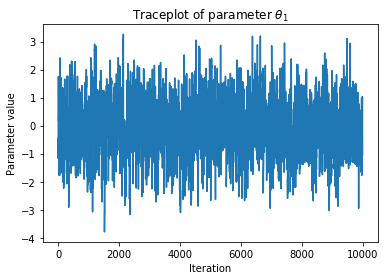

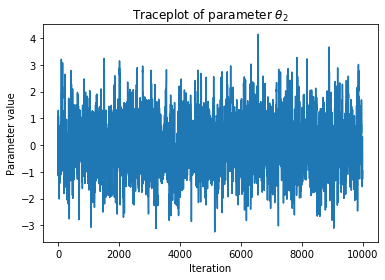

In [11]:
## Plot traces of simulated Markov chain

for i in range(densities[chain_id].num_params()):
    chain = sampler.chains[chain_id].get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter $\theta_{}$'.format(i+1))

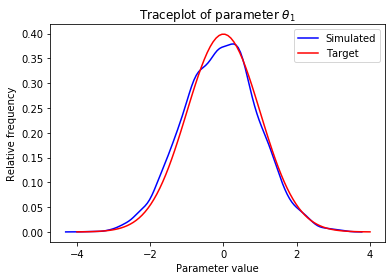

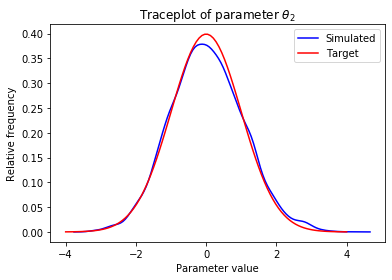

In [12]:
## Plot histograms of marginals of simulated Markov chain

x_hist_range = np.linspace(-4, 4, 100)

for i in range(densities[chain_id].num_params()):
    plt.figure()
    plot = sns.distplot(
        sampler.chains[chain_id].get_theta(i), hist=False, color='blue', label='Simulated'
    )
    plot.set_xlabel('Parameter value')
    plot.set_ylabel('Relative frequency')
    plot.set_title(r'Traceplot of parameter $\theta_{}$'.format(i+1))
    sns.lineplot(x_hist_range, stats.norm.pdf(x_hist_range, 0, 1), color='red', label='Target')
    plot.legend()

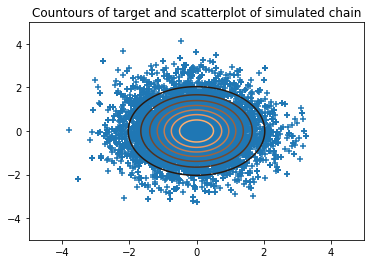

In [13]:
## Plot scatter of simulated Markov chain

x_contour_range, y_contour_range = np.mgrid[-5:5:.01, -5:5:.01]

contour_grid = np.empty(x_contour_range.shape+(2,))
contour_grid[:, :, 0] = x_contour_range
contour_grid[:, :, 1] = y_contour_range

target = stats.multivariate_normal([0., 0.], [[1., 0.], [0., 1.]])

plt.scatter(x=sampler.chains[chain_id].get_theta(0), y=sampler.chains[chain_id].get_theta(1), marker='+')
plt.contour(x_contour_range, y_contour_range, target.pdf(contour_grid), cmap='copper')
plt.title('Countours of target and scatterplot of simulated chain');

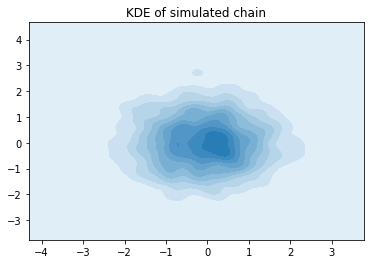

In [14]:
## Plot KDE of target of simulated Markov chain

plot = sns.kdeplot(
    sampler.chains[chain_id].get_theta(0),
    sampler.chains[chain_id].get_theta(1),
    shade=True
)
plot.set_title('KDE of simulated chain');

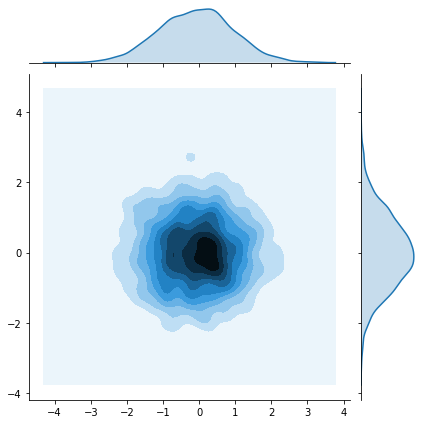

In [15]:
## Plot KDEs of target and of marginals of simulated Markov chain

plot = sns.jointplot(
    sampler.chains[chain_id].get_theta(0),
    sampler.chains[chain_id].get_theta(1),
    kind="kde"
)

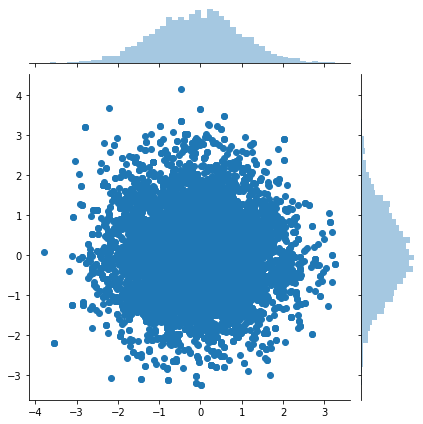

In [16]:
## Plot scatter of target and histograms of marginals of simulated Markov chain

sns.jointplot(
    sampler.chains[chain_id].get_theta(0),
    sampler.chains[chain_id].get_theta(1),
    kind="scatter"
);